In [72]:
%run "../config.py"

declared 5 variables


In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [74]:
class Net(nn.Module):
    def __init__(self, num_channels) -> None:
        super(Net, self).__init__()

        self.num_channels = num_channels
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels * 2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels * 2, self.num_channels * 4, 3, stride=1, padding=1)

        self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)

    def forward(self, x): # (3, 64, 64)
        x = self.conv1(x) # (n, 64, 64)
        x = F.relu(F.max_pool2d(x, 2)) # (n, 32, 32)
        x = self.conv2(x) # (2*n, 32, 32)
        x = F.relu(F.max_pool2d(x, 2)) # (2*n, 16, 16)
        x = self.conv3(x) # (2*n, 16, 16)
        x = F.relu(F.max_pool2d(x, 2)) # (4*n, 8, 8)

        # flatten
        x = x.view(-1, self.num_channels*4*8*8)

        # fc
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # softmax
        x = F.log_softmax(x, dim=1)
        
        return x


In [75]:
DIR = globals()['SIGNS_DIR'].joinpath("64x64_SIGNS")

In [76]:
DIR

PosixPath('/home/rml/dev/pytorch/datasets/SIGNS/64x64_SIGNS')

In [77]:
import sys
sys.path.append(str(BASE_DIR))

In [78]:
from plot_helpers import imshow
import pathlib
from PIL import Image

In [79]:
class SIGNSDataset():
    def __init__(self, base_dir: str | pathlib.Path, split: str = "train", transform = None) -> None:
        if isinstance(base_dir, str): base_dir = pathlib.Path(base_dir)
        path = base_dir.joinpath(split)
        files = path.iterdir()

        self.filenames = list(filter(lambda x: str(x).endswith(".jpg"), files))
        self.labels = [int(f.name[0]) for f in self.filenames]
        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)
    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]    

In [80]:
signs = SIGNSDataset(DIR, "train_signs")

In [81]:
len(signs)

864

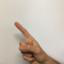

In [82]:
signs[0][0]

In [83]:
import torchvision.transforms as transforms

In [84]:
train_signs = SIGNSDataset(DIR, "train_signs", transform=transforms.ToTensor())

In [85]:
train_signs[0][0]

tensor([[[0.8627, 0.8627, 0.8627,  ..., 0.8627, 0.8588, 0.8588],
         [0.8627, 0.8627, 0.8588,  ..., 0.8627, 0.8588, 0.8588],
         [0.8627, 0.8588, 0.8588,  ..., 0.8627, 0.8588, 0.8588],
         ...,
         [0.7647, 0.7647, 0.7608,  ..., 0.7529, 0.7569, 0.7608],
         [0.7490, 0.7451, 0.7451,  ..., 0.6941, 0.7098, 0.7059],
         [0.7333, 0.7333, 0.7333,  ..., 0.6157, 0.6549, 0.6588]],

        [[0.8353, 0.8353, 0.8353,  ..., 0.8314, 0.8275, 0.8275],
         [0.8353, 0.8353, 0.8314,  ..., 0.8314, 0.8275, 0.8275],
         [0.8353, 0.8314, 0.8314,  ..., 0.8314, 0.8275, 0.8275],
         ...,
         [0.7255, 0.7255, 0.7216,  ..., 0.7098, 0.7216, 0.7255],
         [0.7098, 0.7059, 0.7059,  ..., 0.6431, 0.6667, 0.6627],
         [0.6941, 0.6941, 0.6941,  ..., 0.5647, 0.6118, 0.6157]],

        [[0.7725, 0.7725, 0.7725,  ..., 0.7882, 0.7843, 0.7843],
         [0.7725, 0.7725, 0.7686,  ..., 0.7882, 0.7843, 0.7843],
         [0.7725, 0.7686, 0.7686,  ..., 0.7882, 0.7843, 0.

In [86]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

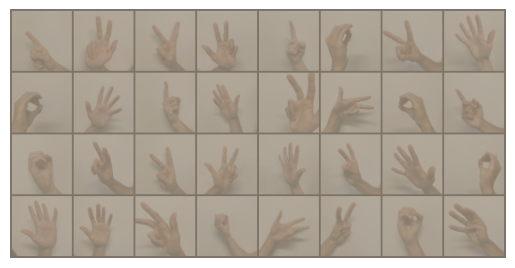

tensor([1, 3, 2, 3, 1, 0, 2, 5, 0, 5, 1, 5, 3, 3, 0, 1, 0, 2, 2, 3, 5, 2, 5, 0,
        5, 5, 3, 0, 3, 2, 0, 4])


In [87]:
dataloader = DataLoader(train_signs, batch_size=32)
for inputs, targets in dataloader:
    out = make_grid(inputs)
    imshow(out)
    print(targets)
    break

In [88]:
import torch.optim as optim

In [89]:
device = torch.device('cpu')
net = Net(32).to_device('cpu')
# loss_fn = 

In [94]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [103]:
class RunningMetric():
    def __init__(self) -> None:
        self.S = 0
        self.N = 0
    
    def update(self, val, size):
        self.S += val
        self.N += size

    def __call__(self):
        try:
            return self.S / float(self.N)
        except ZeroDivisionError as e:
            return 0

In [104]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    print("Epoch {} / {}".format(epoch, num_epochs))
    print("-"*10)

    running_loss = RunningMetric()
    running_ac  = RunningMetric()

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        batch_size = inputs.size()[0]
        running_loss.update(batch_size*loss.item(),
                            batch_size)
        running_ac.update(torch.sum(preds == targets),
                            batch_size)
        print("Loss: {:4f} - Accuracy {:4f}".format(running_loss(), running_ac()))

Epoch 1 / 100
----------
Loss: 1.709553 - Accuracy 0.218750
Loss: 1.598496 - Accuracy 0.328125
Loss: 1.582059 - Accuracy 0.354167
Loss: 1.569138 - Accuracy 0.414062
Loss: 1.561721 - Accuracy 0.418750
Loss: 1.581661 - Accuracy 0.395833
Loss: 1.578829 - Accuracy 0.397321
Loss: 1.580947 - Accuracy 0.394531
Loss: 1.579648 - Accuracy 0.392361
Loss: 1.580572 - Accuracy 0.390625
Loss: 1.583162 - Accuracy 0.377841
Loss: 1.590948 - Accuracy 0.375000
Loss: 1.586101 - Accuracy 0.377404
Loss: 1.590389 - Accuracy 0.370536
Loss: 1.588656 - Accuracy 0.372917
Loss: 1.586200 - Accuracy 0.371094
Loss: 1.577410 - Accuracy 0.376838
Loss: 1.576725 - Accuracy 0.375000
Loss: 1.583768 - Accuracy 0.379934
Loss: 1.591553 - Accuracy 0.371875
Loss: 1.597367 - Accuracy 0.366071
Loss: 1.597569 - Accuracy 0.363636
Loss: 1.591201 - Accuracy 0.366848
Loss: 1.586885 - Accuracy 0.372396
Loss: 1.580300 - Accuracy 0.372500
Loss: 1.577624 - Accuracy 0.368990
Loss: 1.578856 - Accuracy 0.365741
Epoch 2 / 100
----------
Loss:

KeyboardInterrupt: 